# Packages

In [ ]:
from preProcessing_class import DataHandler
from modellingPipeLine import ChurnModelling

from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle

# Modelling PipeLine

### Dataset

In [2]:
df = pd.read_csv("ecommerce_customer_data_large.csv", sep=",")

processingPipeLine = DataHandler(df, cutting=[18, 30, 70]) # minimum age: 18, maximum age: 70
processingPipeLine.preProcessing()  

data=processingPipeLine.dataAgg

*setting parameters*

In [3]:
cv_lasso=3        # cv folds for tuning the best lasso lambda
range_knn=26      # max range of neighbors for the knn model
cv_knn=3          # cv folds for tuning the best k.nearest neighbors
range_tree=36     # max depth of the tree in the tree model
cv_tree=3         # cv folds for tuning the best depth of the tree
seed=123          # set random seed

folders_splitting_test_train = 3  # cv folds for the scoring metrics

### Cross-validation

In [4]:
modellingPipeLine = ChurnModelling(set_seed=seed)

In [5]:
kf = KFold(n_splits=folders_splitting_test_train, shuffle=True, random_state=seed)
list_y_test = []
dict_models = {}
scoreMatrix = []
confusionMatrix = {}

i = 0
# making cross-validation
for train_index, test_index in kf.split(data):
    # splitting train/test
    data_train = data.iloc[train_index]
    data_test = data.iloc[test_index]
    # calling method "modelling" giving as parameters data_train e data_test
    models, y_test, score_matrix_test = modellingPipeLine.modelling(data_train, data_test, cv_lasso, range_knn, cv_knn, range_tree, cv_tree)
    # dictionary with the models predictions
    dict_models[i] = models
    # list with the y_test for each cross validation
    list_y_test.append(y_test)
    # list with the score matrix for each cross validation (f1 and precision)
    scoreMatrix.append(score_matrix_test)
    # dictionary with confusion matrix for each model for each cross validation
    confusionMatrix[i] = (modellingPipeLine.confusion_matrix(models, y_test))

    i+=1

In [ ]:
saving_vars = [dict_models, list_y_test, scoreMatrix, confusionMatrix]

with open('ambiente.pkl', 'wb') as f:
    pickle.dump(saving_vars, f)

In [ ]:
with open('ambiente.pkl', 'rb') as f:
    dict_models, list_y_test, scoreMatrix, confusionMatrix = pickle.load(f)

## Models evaluation

*confusion matrix*

In [29]:
for i in range(0, folders_splitting_test_train):
  print(f"Cross-validation: {i+1}\n")
  for name, pred in dict_models[i].items():
    print(name)
    print(confusionMatrix[i][name], "\n")

Cross-validation: 1

Baseline Random
       0     1
0  10469  2674
1   2628   611 

Baseline Zeros
       0  1
0  13143  0
1   3239  0 

Baseline Ones
   0      1
0  0  13143
1  0   3239 

Logistic Regression
       0  1
0  13143  0
1   3239  0 

Lasso CV
   0      1
0  0  13143
1  0   3239 

Naive Bayes
       0  1
0  13143  0
1   3239  0 

K-Nearest Neighbors
       0     1
0  10555  2588
1   2564   675 

Decision Tree
       0     1
0  10244  2899
1   2531   708 

Cross-validation: 2

Baseline Random
       0     1
0  10449  2630
1   2637   666 

Baseline Zeros
       0  1
0  13079  0
1   3303  0 

Baseline Ones
   0      1
0  0  13079
1  0   3303 

Logistic Regression
       0  1
0  13079  0
1   3303  0 

Lasso CV
   0      1
0  0  13079
1  0   3303 

Naive Bayes
       0  1
0  13079  0
1   3303  0 

K-Nearest Neighbors
       0     1
0  10555  2524
1   2626   677 

Decision Tree
       0     1
0  10107  2972
1   2565   738 

Cross-validation: 3

Baseline Random
       0     1
0  1

*score matrix: precision, f1*

In [35]:
# inizialization
final_score_matrix = {}
# double for: model - crossa validation index
for model_index in range(0, len(dict_models[0].keys())):
    temp_precision_sum = 0
    temp_f1_sum = 0
    for cv_index in range(0, folders_splitting_test_train):
        # temporary sums for precision and f1
        temp_precision_sum += scoreMatrix[cv_index]['precision'][model_index]
        temp_f1_sum += scoreMatrix[cv_index]['f1'][model_index]
    # final dictionary with the average value for precision and model for each model
    final_score_matrix[scoreMatrix[cv_index]['model'][model_index]] = {'Precision': temp_precision_sum/folders_splitting_test_train, 
                                                    'F1': temp_f1_sum/folders_splitting_test_train}
# changing dict into df
final_score_matrix = pd.DataFrame.from_dict(final_score_matrix, orient='index').reset_index()
final_score_matrix.columns = ['Modello', 'Precision', 'F1']

final_score_matrix

,Modello,Precision,F1
0,Baseline Random,0.193818,0.194710
1,Baseline Zeros,0.000000,0.000000
2,Baseline Ones,0.199772,0.333014
3,Logistic Regression,0.000000,0.000000
4,Lasso CV,0.199817,0.333076
5,Naive Bayes,0.000000,0.000000
6,K-Nearest Neighbors,0.205243,0.204312
7,Decision Tree,0.197935,0.209422


*roc curve*

In [36]:
# dictionary with all the roc/auc values
dict_roc_auc = {}
for i in range(0, folders_splitting_test_train):
    dict_roc_auc[i] = modellingPipeLine.roc_curve_plot(dict_models[i], list_y_test[i])

final_roc_dict = {}
# double for: model - cross validation index
for model_name in dict_models[0].keys():
    # inizialization:
    temp_fpr_append = []
    temp_tpr_append = []
    temp_auc_score_sum = 0
    for cv_index in range(0, folders_splitting_test_train):
        # appending arrays
        temp_fpr_append.append(dict_roc_auc[cv_index][model_name]['fpr'])
        temp_tpr_append.append(dict_roc_auc[cv_index][model_name]['tpr'])
        # calculating temp sum
        temp_auc_score_sum += dict_roc_auc[cv_index][model_name]['auc_score']
    
    # check if all the arrays have same legnth, otherwise adding 1
    max_length = max(len(fpr) for fpr in temp_fpr_append)
    temp_fpr_append = [np.pad(fpr, (0, max_length - len(fpr)), 'constant', constant_values=1) for fpr in temp_fpr_append]
    max_length = max(len(tpr) for tpr in temp_tpr_append)
    temp_tpr_append = [np.pad(tpr, (0, max_length - len(tpr)), 'constant', constant_values=1) for tpr in temp_tpr_append]
    
    # calculating average values
    final_roc_dict[model_name] = {'fpr': np.mean(temp_fpr_append, axis=0),
                                    'tpr': np.mean(temp_tpr_append, axis=0),
                                    'auc_score': temp_auc_score_sum/folders_splitting_test_train}

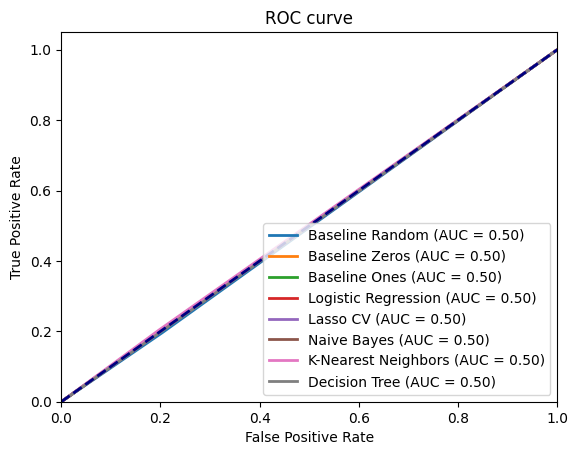

In [37]:
plt.figure()
for name, values in final_roc_dict.items():
    plt.plot(values['fpr'], values['tpr'], lw=2, label=f'{name} (AUC = {values['auc_score']:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')       
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()